# Introduction

This notebook is supplementary material to Stocker et al. "Towards research infrastructures that curate scientific information: A use case in life sciences" originally submitted to the [13th International Conference on Data Integration in the Life Sciences](https://events.tib.eu/dils2018/) (DILS 2018), November 20-21, Hannover, Germany.

The notebook reproduces and proposes an alternative (and complementary) representation of a result published by [Haddad et al. (2017)](https://doi.org/10.1093/eurheartj/ehw333). Specifically, we reproduce the statistical hypothesis test underlying the statement "IRE binding activity was significantly reduced in failing hearts" using the data shown in Figure 1B (p. 364). 

In contrast to the conventional representation of a p-value, a plot and a natural language statement, we demonstrate how this results can be represented as a machine readable description for the statistical hypothesis test, specifically a two sample t-test with unequal variance with two continuous variables (and their corresponding values), the study design dependent variable, and the p-value.

Finally, we demonstrate how the machine readable description for the statistical hypothesis test can be linked to the corresponding natural language sentence in the article by Haddad et al., thus linking the result with article metadata, e.g. author ORCID iD or article DOI.

In [1]:
import io
import re
import requests
import numpy as np
import pandas as pd
from  urllib.parse import quote
from scipy.stats import ttest_ind
from pyRdfa import pyRdfa
from rdflib import Graph, URIRef, BNode, Literal
from rdflib.namespace import RDF, XSD, RDFS
from rdflib.plugins.sparql.results.csvresults import CSVResultSerializer

In [2]:
obo = dict()

obo['STATO_0000304'] = URIRef('http://purl.obolibrary.org/obo/STATO_0000304')
obo['OBI_0000299'] = URIRef('http://purl.obolibrary.org/obo/OBI_0000299')
obo['OBI_0000175'] = URIRef('http://purl.obolibrary.org/obo/OBI_0000175')
obo['OBI_0000293'] = URIRef('http://purl.obolibrary.org/obo/OBI_0000293')
obo['STATO_0000251'] = URIRef('http://purl.obolibrary.org/obo/STATO_0000251')
obo['BFO_0000051'] = URIRef('http://purl.obolibrary.org/obo/BFO_0000051')
obo['IAO_0000032'] = URIRef('http://purl.obolibrary.org/obo/IAO_0000032')
obo['OBI_0001938'] = URIRef('http://purl.obolibrary.org/obo/OBI_0001938')
obo['OBI_0001933'] = URIRef('http://purl.obolibrary.org/obo/OBI_0001933')
obo['OBI_0001931'] = URIRef('http://purl.obolibrary.org/obo/OBI_0001931')
obo['OBI_0002135'] = URIRef('http://purl.obolibrary.org/obo/OBI_0002135')
obo['OBI_0001937'] = URIRef('http://purl.obolibrary.org/obo/OBI_0001937')
obo['OBI_0000751'] = URIRef('http://purl.obolibrary.org/obo/OBI_0000751')
obo['STATO_0000205'] = URIRef('http://purl.obolibrary.org/obo/STATO_0000205')
obo['STATO_0000019'] = URIRef('http://purl.obolibrary.org/obo/STATO_0000019')
obo['STATO_0000129'] = URIRef('http://purl.obolibrary.org/obo/STATO_0000129')
obo['GO_0030350'] = URIRef('http://purl.obolibrary.org/obo/GO_0030350')
obo['NCIT_C50577'] = URIRef('http://purl.obolibrary.org/obo/NCIT_C50577')
obo['NCIT_C25168'] = URIRef('http://purl.obolibrary.org/obo/NCIT_C25168')

def create_ttest_description(df, tt):
    g = Graph()

    g.bind('obo', 'http://purl.obolibrary.org/obo/')
    g.bind('ex', 'http://example.org/')

    n1 = URIRef('https://doi.org/10.1093/eurheartj/ehw333-R1')
    n2 = BNode()
    n3 = BNode()
    n4 = BNode()
    n5 = BNode()
    n6 = BNode()
    
    g.add((obo['STATO_0000304'], RDFS.label, Literal('two sample t-test with unequal variance')))
    g.add((obo['OBI_0000299'], RDFS.label, Literal('has specified output')))
    g.add((obo['OBI_0000293'], RDFS.label, Literal('has specified input')))
    g.add((obo['OBI_0000175'], RDFS.label, Literal('p-value')))
    g.add((obo['OBI_0001938'], RDFS.label, Literal('has value specification')))
    g.add((obo['OBI_0001931'], RDFS.label, Literal('scalar value specification')))
    g.add((obo['OBI_0001937'], RDFS.label, Literal('has specified numeric value')))
    g.add((obo['OBI_0000751'], RDFS.label, Literal('study design dependent variable')))
    g.add((obo['OBI_0001933'], RDFS.label, Literal('value specification')))
    g.add((obo['OBI_0002135'], RDFS.label, Literal('has specified value')))
    g.add((obo['GO_0030350'], RDFS.label, Literal('iron-responsive element binding')))
    g.add((obo['STATO_0000251'], RDFS.label, Literal('continuous variable')))
    g.add((obo['BFO_0000051'], RDFS.label, Literal('has part')))
    g.add((obo['IAO_0000032'], RDFS.label, Literal('scalar measurement datum')))
    g.add((obo['STATO_0000129'], RDFS.label, Literal('has value')))
    g.add((obo['STATO_0000019'], RDFS.label, Literal('normal distribution hypothesis')))
    g.add((obo['STATO_0000205'], RDFS.label, Literal('is denoted by')))
    g.add((obo['NCIT_C50577'], RDFS.label, Literal('heart failure')))
    g.add((obo['NCIT_C25168'], RDFS.label, Literal('tissue donor')))

    g.add((n1, RDF.type, obo['STATO_0000304']))
    g.add((n1, obo['OBI_0000299'], n2))
    g.add((n2, RDF.type, obo['OBI_0000175']))
    g.add((n2, obo['OBI_0001938'], n3))
    g.add((n3, RDF.type, obo['OBI_0001931']))
    g.add((n3, obo['OBI_0001937'], Literal(tt.pvalue, datatype=XSD.double)))
    g.add((n1, obo['OBI_0000293'], n4))
    g.add((n4, RDF.type, obo['OBI_0000751']))
    g.add((n4, RDF.type, obo['GO_0030350']))
    
    for c in list(df):
        b1 = BNode()
        g.add((n1, obo['OBI_0000293'], b1))
        g.add((b1, RDF.type, obo['STATO_0000251']))
        for v in df[c]:
            if np.isnan(v): 
                continue
            b2 = BNode()
            b3 = BNode()
            g.add((b1, RDFS.label, Literal(c)))
            g.add((b1, obo['BFO_0000051'], b2))
            g.add((b2, RDF.type, obo['IAO_0000032']))
            g.add((b2, obo['OBI_0001938'], b3))
            g.add((b3, RDF.type, obo['OBI_0001931']))
            g.add((b3, obo['OBI_0001937'], Literal(str(v), datatype=XSD.double)))

    return g

def query(g, q):
    serializer = CSVResultSerializer(g.query(q))
    output = io.BytesIO()
    serializer.serialize(output)
    return pd.read_csv(io.StringIO(output.getvalue().decode('utf-8')))

## Data Analysis

We first perform the statistical hypothesis test. This is a step of the data analysis phase of the research lifecycle. The conventional and the proposed approaches largely share this step, the main difference being that in the conventional approach researchers use [Prism](https://www.graphpad.com/scientific-software/prism/) rather than Jupyter. We obtain the p-value.

In [3]:
labels = ['non-failing heart (NF)', 'failing heart (F)']
data = [(99, 52), (96, 40), (100, 38), (105, 18), 
        (np.nan, 11), (np.nan, 5), (np.nan, 42), 
        (np.nan, 55), (np.nan, 53), (np.nan, 39),
        (np.nan, 42), (np.nan, 50)]

df = pd.DataFrame.from_records(data, columns=labels)
tt = ttest_ind(df['non-failing heart (NF)'], 
               df['failing heart (F)'], 
               equal_var=False, nan_policy='omit')

tt.pvalue

1.3111247517411591e-08

Here is where the proposed approach diverges from the conventional one. We suggest to use the [STATO](http://stato-ontology.org/) general purpose statistics ontology, the [Ontology for Biomedical Investigations](http://obi-ontology.org/) (OBI), the [Information Artifact Ontology](http://www.obofoundry.org/ontology/iao.html) (IAO), and the [Gene Ontology](http://www.geneontology.org/) (GO) (among others) to create a machine readable description of the statistical hypothesis test.

In [4]:
g = create_ttest_description(df, tt)

We can look at the resulting machine readable description, which is an RDF graph.

In [5]:
print(g.serialize(format='turtle').decode('utf-8'))

@prefix ex: <http://example.org/> .
@prefix obo: <http://purl.obolibrary.org/obo/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

obo:BFO_0000051 rdfs:label "has part" .

obo:NCIT_C25168 rdfs:label "tissue donor" .

obo:NCIT_C50577 rdfs:label "heart failure" .

obo:OBI_0000293 rdfs:label "has specified input" .

obo:OBI_0000299 rdfs:label "has specified output" .

obo:OBI_0001933 rdfs:label "value specification" .

obo:OBI_0001937 rdfs:label "has specified numeric value" .

obo:OBI_0001938 rdfs:label "has value specification" .

obo:OBI_0002135 rdfs:label "has specified value" .

obo:STATO_0000019 rdfs:label "normal distribution hypothesis" .

obo:STATO_0000129 rdfs:label "has value" .

obo:STATO_0000205 rdfs:label "is denoted by" .

<https://doi.org/10.1093/eurheartj/ehw333-R1> a obo:STATO_0000304 ;
    obo:OB

Given such a machine readable description, we can execute SPARQL queries. 

The following is for two sample t-tests with unequal variance with iron-responsive element binding as dependent variable and p-value < 0.005.

In [6]:
display(query(g, """
PREFIX obo: <http://purl.obolibrary.org/obo/>
SELECT ?test ?pvalue WHERE {
 ?test a obo:STATO_0000304 ;                        # a two sample t-test with unequal variance
    obo:OBI_0000299 [                               # that has specified output
        a obo:OBI_0000175 ;                         # a p-value
        obo:OBI_0001938 [                           # that has value specification
            a obo:OBI_0001931 ;                     # a scalar value specification
            obo:OBI_0001937 ?pvalue                 # that has specified numeric value ?pvalue
        ] 
    ] .
 ?test obo:OBI_0000293 [                            # and has specified input
    a obo:OBI_0000751, obo:GO_0030350 ;             # a study design dependent variable, iron-responsive element binding
 ] . 
 FILTER (?pvalue < 0.005)
}
"""))

test        pvalue
0  https://doi.org/10.1093/eurheartj/ehw333-R1  1.311125e-08

The following query extracts the data of the two variables, creates a data frame and plots the data.

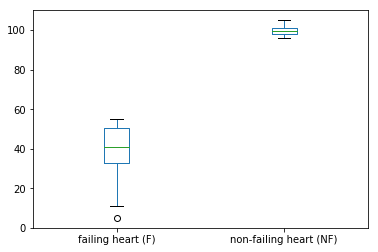

In [7]:
%matplotlib inline

df = query(g, """
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX : <https://doi.org/10.1093/eurheartj/>
SELECT ?variable ?value WHERE {
 :ehw333-R1 a obo:STATO_0000304 .           # the two sample t-test with unequal variance
 :ehw333-R1 obo:OBI_0000293 ?v .            # that has specified input
 ?v a obo:STATO_0000251 .                   # a continuous variable
 ?v rdfs:label ?variable .                  # with label
 ?v obo:BFO_0000051 [                       # that has part
    a obo:IAO_0000032 ;                     # a scalar measurement datum
    obo:OBI_0001938 [                       # that has value specification
        a obo:OBI_0001931 ;                 # a scalar value specification
        obo:OBI_0001937 ?value              # that has specified numeric value
    ]
 ]
}
ORDER BY (?variable)
""")

df.pivot(columns='variable', values='value').plot.box()

## Linking to Article Text

We can now link the statistical hypothesis test description obtained in the data analysis phase of the research lifecycle with article text created during the scholarly communication phase of the research lifecycle. This allows us to extend the description with article (meta)data, such as author names and ORCID iDs or article DOI. Here we use [dokieli](https://dokie.li) and reproduce relevant article text with RDFa annotations. 

Take a look at the [RDFa annotated article](https://mstocker.solid.community/public/haddad17iron.html).

First we read the annotations.

In [8]:
r = g.parse('https://mstocker.solid.community/public/haddad17iron.html', format='rdfa')

We can now ask for articles that report highly significant results on some dependent variable.

In [9]:
display(query(g, """
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX bibo: <http://purl.org/ontology/bibo/>
PREFIX dc: <http://purl.org/dc/terms/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX vivo: <http://vivoweb.org/ontology/core#>
PREFIX orkg: <http://orkg.org/core#>
SELECT ?title ?doi ?firstname ?lastname ?orcidId ?variable WHERE {
  ?a a bibo:Article, orkg:ResearchContribution .  # articles
  ?a dc:title ?title .                            # their title, DOI, and authors with ORCID iD
  ?a bibo:doi ?doi .                              
  ?a dc:creator [ foaf:givenname ?firstname; foaf:family_name ?lastname; vivo:orcidId ?orcidId ] .
  ?a orkg:yields ?r .                             # that yield research results
  ?r a orkg:ResearchResult, obo:STATO_0000304 .   # that are two sample t-test with unequal variance
  ?r obo:OBI_0000299 [                            # that has specified output
    a obo:OBI_0000175 ;                           # a p-value
    obo:OBI_0001938 [                             # that has value specification
      a obo:OBI_0001931 ;                         # a scalar value specification
      obo:OBI_0001937 ?pvalue                     # that has specified numeric value ?pvalue
    ]
  ] . 
  ?r obo:OBI_0000293 [                            # and has specified input
    a [ rdfs:label ?variable ] ;                  # a study design dependent variable
  ] . 
  FILTER (?pvalue < 0.001                         # highly significant results
    && ?variable != 'continuous variable'
    && ?variable != 'study design dependent variable')
}
"""))

title  \
0  Iron-regulatory proteins secure iron availabil...   

                                        doi firstname lastname  \
0  https://doi.org/10.1093/eurheartj/ehw333   Fatemeh  Rostami   

                                orcidId                         variable  
0  http://orcid.org/0000-0002-0992-6227  iron-responsive element binding